# Information extraction from Madison city crime incident reports using Deep Learning

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li>
<li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-4">Data preparation</a></span></li>
<li><span><a href="#Model-training" data-toc-modified-id="Model-training-5">Model training</a></span></li>
<ul class="toc-item">
<li><span><a href="#Validate-results" data-toc-modified-id="Validate-results-5.1">Validate results</a></span></li>
<li><span><a href="#Save-and-load-trained-models" data-toc-modified-id="Save-and-load-trained-models-5.2">Save and load trained models</a></span></li>
</ul>
<li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-6">Model inference</a></span></li>
<li><span><a href="#Publishing-the-results-as-feature-layer" data-toc-modified-id="Publishing-the-results-as-feature-layer-7">Publishing the results as feature layer</a></span></li>
<li><span><a href="#Visualize-crime-incident-on-map" data-toc-modified-id="Visualize-crime-incident-on-map- 8">Visualize crime incident on map</a></span></li>
<li><span><a href="#Create-a-hot-spot-map-of-crime-densities" data-toc-modified-id="Create-a-hot-spot-map-of-crime-densities-9">Create a hot spot map of crime densities</a></span></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10">Conclusion</a></span></li>
<li><span><a href="#References" data-toc-modified-id="References-11">References</a></span></li>
</ul></div>

# Introduction
Crime analysis is an essential part of efficient law enforcement for any city. It involves:
-	Collecting data in a form that can be analyzed. 
-	Identifying spatial/non-spatial patterns and trends in the data. 
-	Informed decision making based on the analysis.

In order to start the analysis, the first and foremost requirement is analyzable data. A huge volume of data is present in the witness and police narratives of the crime incident. Few examples of such information are:
-	Place of crime
-	Nature of crime
-	Date and time of crime
-	Suspect
-	Witness

Extracting such information from incident reports requires tedious work. Crime analysts have to sift through piles of police reports to gather and organize this information.

With recent advancements in Natural Language Processing and Deep learning, its possible to devise an automated workflow to extract information from such unstructured text documents. In this notebook we will extract information from crime incident reports obtained from Madison police department [[1]](#References)using `arcgis.learn.EntityRecognizer()`.

# Prerequisites

- Data preparation and model training workflows using arcgis.learn have a dependency on spaCy. This can be installed using conda as follows: `conda install -c esri arcgis fastai spacy scikit-image`
- Labelled data: In order for Entity Recognizer to learn, it needs to see examples that have been labelled for all the custom categories that the model is expected to extract. Labelled data for this sample notebook is located at data/EntityRecognizer/labelled_crime_reports.json
- Test documents to extract named entities are in a zipped file at data/EntityRecognizer/reports.zip
- To learn more on how `EntityRecognizer` works, please see the guide on [Named Entity Extraction Workflow with arcgis.learn](https://developers.arcgis.com/python/sample-notebooks/how-named-entity-recognition-works/).

# Imports

In [1]:
from arcgis.learn import prepare_data
from arcgis.learn import EntityRecognizer
import re
import os
import pandas as pd
from arcgis.gis import GIS
from arcgis.geocoding import batch_geocode
import zipfile,unicodedata
from itertools import repeat

In [2]:
gis = GIS("your_online_profile")

# Data preparation

Data preparation involves splitting the data into training and validation sets, creating the necessary data structures for loading data into the model and so on.  The `prepare_data()` method can directly read the training samples in one of the above specified formats and automate the entire process.

In [3]:
json_path = os.path.join("data", "EntityRecognizer", "labelled_crime_reports.json")

In [4]:
data = prepare_data(path= json_path, 
                    class_mapping={'address_tag':'Address'}, 
                    dataset_type='ner_json')

The `show_batch()` method can be used to visualize the training samples, along with labels.

In [5]:
data.show_batch()

,Address,Crime,Crime_datetime,Reported_date,Reported_time,Reporting_officer,Weapon,text
0,[1700 block of Fordem Ave],"[mugging, punched her in the face several time...",,[11/21/2016],[10:10 AM],[PIO Joel Despain],,A Sunday night dog walk turned into a mugging ...
1,"[N. High Point Rd., Crestwood Neighborhood]",,[Saturday night],[04/02/2018],[9:56 AM],[PIO Joel Despain],,MPD officers warned adults in charge of a grou...
2,[5300 block of Groveland Terrace],"[fight, shots had been fired, altercation, gun...",[5:34 AM],[11/23/2017],[9:42 AM],[Sgt. Eric Tripke],,At 5:34 AM Officers were sent to the 5300 bloc...
3,[Southwest Commuter Path near N. Orchard St.],,,,[10:41 AM],[PIO Joel Despain],"[arrow, bow and arrow]",A bicyclist said a bowman pointed an arrow at ...
4,"[East Towne, mall's parking lot]","[battery, punched in the face]","[Tuesday, night prior]",[09/28/2016],[12:33 PM],[PIO Joel Despain],,A 20-year-old East Towne employee contacted th...
5,,,,[06/06/2019],[11:11 AM],[PIO Joel Despain],,A 13-year-old girl became scared last night af...
6,"[122 E. Gilman Street (Lakeshore Apartments), ...","[Armed Robbery/Substantial Battery, pistol whi...","[June 11, 2019 at approximately 11:09pm]",[06/12/2019],[1:15 AM],[Sgt. Nathan Becker],[firearm],"On June 11, 2019 at approximately 11:09pm, Mad..."
7,"[Knutson Dr., Heffernan Dr.]",[shots being fired],[1/26/18 at approximately 11:05 PM],[01/27/2018],[12:37 AM],[Sgt. Kurt Wege],[bullets],On 1/26/18 at approximately 11:05 PM the Madis...


# Model training

- First we will create model using the `EntityRecognizer()` constructor and passing it the data object.
- Training the model is an iterative process. We can train the model using its fit() method till the [f1_score](https://en.wikipedia.org/wiki/F1_score) (maximum possible value = 1) continues to improve with each training pass, also known as epoch. This is indicative of the model getting better at predicting the correct labels.

In [6]:
ner = EntityRecognizer(data)

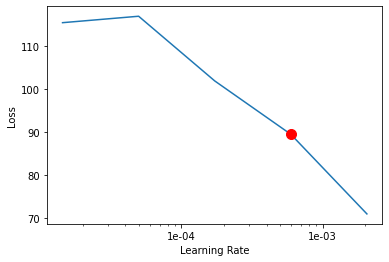

In [7]:
lr=ner.lr_find()

In [8]:
ner.fit(epochs=80,lr=lr)

epoch,losses,val_loss,precision_score,recall_score,f1_score
0,76.94,16.16,0.0,0.0,0.0
1,19.56,16.96,0.0,0.0,0.0
2,17.46,10.66,0.95,0.4,0.57
3,16.77,11.29,0.87,0.35,0.5
4,11.76,25.39,0.36,0.18,0.24
5,31.47,8.95,0.6,0.28,0.39
6,13.91,19.67,0.52,0.36,0.43
7,19.68,29.19,0.55,0.36,0.43
8,25.11,14.72,0.67,0.44,0.53
9,35.15,28.63,0.24,0.07,0.1


## Validate results

Now we have the trained model, let's look at how the model performs.

In [9]:
ner.show_results()

,TEXT,Filename,Address,Crime,Crime_datetime,Reported_date,Reported_time,Reporting_officer,Weapon
0,A City of Madison Parking Enforcement Officer ...,Example_0,1400 Block of Morrison St,"stolen,stolen","June 21, 2016",06/24/2016,6:28 PM,Sgt. Nicholas Ellis,
1,A City of Madison Parking Enforcement Officer ...,Example_0,Riley's Wines of the World,"stolen,stolen","June 21, 2016",06/24/2016,6:28 PM,Sgt. Nicholas Ellis,
2,A Madison man reported being robbed of cash an...,Example_1,N. Marquette St.,robbed,last night,09/14/2016,10:34 AM,PIO Joel Despain,handgun
3,Officers responded to an alarm at Dick's Sport...,Example_2,"Dick's Sporting Goods, 237 West Towne Mall",,,04/27/2017,3:37 AM,Lt. Timothy Radke,13 airsoft and pellet guns
4,Victim was walking northbound in the 600 block...,Example_3,600 block of West Washington,grabbed her purse,,01/06/2019,8:37 AM,Sgt. John Rife,
5,A McDonald's employee suffered a knee injury a...,Example_4,Odana Rd. restaurant,"strong-armed robbery,grabbed money",Monday night,01/19/2016,9:44 AM,PIO Joel Despain,
6,A City of Madison Parking Enforcement Officer ...,Example_5,1400 Block of Morrison St,"stolen,stolen","June 21, 2016",06/24/2016,6:28 PM,Sgt. Nicholas Ellis,
7,A City of Madison Parking Enforcement Officer ...,Example_5,Riley's Wines of the World,"stolen,stolen","June 21, 2016",06/24/2016,6:28 PM,Sgt. Nicholas Ellis,
8,A McDonald's employee suffered a knee injury a...,Example_6,Odana Rd. restaurant,"strong-armed robbery,grabbed money",Monday night,01/19/2016,9:44 AM,PIO Joel Despain,
9,On May 2nd 2019 at approximately 11:56 p.m. Ma...,Example_7,5000 block of Milwaukee St.,"weapons violation,Multiple gunshots were fired...",May 2nd 2019 at approximately 11:56 p.m.,05/03/2019,5:04 AM,Lt. Reginald Patterson,


## Save and load trained models

Once you are satisfied with the model, you can save it using the `save()` method. This creates an Esri Model Definition (EMD file) that can be used for inferencing on new data. 
Saved models can also be loaded back using the `load()` method. `load()` method takes the path to the emd file as a required argument.

In [10]:
ner.save('crime_model')

Model has been saved to D:\D\api_notebooks\samples\04_gis_analysts_data_scientists\data\EntityRecognizer\models\crime_model


In [11]:
model_path = os.path.join("data","EntityRecognizer","models", "crime_model","crime_model.emd")
print(model_path)

data\EntityRecognizer\models\crime_model\crime_model.emd


# Model Inference

Now we can use the trained model to extract entities from new text documents using `extract_entities()` function. This method expects the folder path of where new text document are located, or a list of text documents.

In [12]:
def read_zip_file(filepath): #Reads documents from a zip file and returns a document list
    zfile = zipfile.ZipFile(filepath)
    doc_list=[]
    for finfo in zfile.infolist():
        ifile = zfile.open(finfo)
        line_list = [ line.decode("ansi") for line in ifile.readlines()]
        line_list=list(map(unicodedata.normalize,repeat('NFKD'),line_list))
        doc_list.append(line_list[0])
    return doc_list

In [13]:
reports_path = os.path.join("data", "EntityRecognizer","reports.zip")

In [14]:
report_list = read_zip_file(reports_path) #list of new documents on which predictions are to be made.

In [15]:
results = ner.extract_entities(report_list) #extract_entities()also accepts path of the documents folder as an argument.

In [16]:
results.head()

,TEXT,Filename,Address,Crime,Crime_datetime,Reported_date,Reported_time,Reporting_officer,Weapon
0,Officers were dispatched to a robbery of the ...,Example_0,Associated Bank in the 1500 block of W Broadway,"robbery,demanded money",,08/09/2018,6:17 PM,Sgt. Jennifer Kane,No weapon
1,The MPD was called to Pink at West Towne Mall ...,Example_1,Pink at West Towne Mall,thefts,Tuesday night,08/18/2016,10:37,PIO Joel Despain,
2,"The MPD is seeking help locating a unique $1,...",Example_2,Union St. home,"stolen,thief cut a bike lock,stolen",that night,08/17/2016,11:09 AM,PIO Joel Despain,
3,A Radcliffe Drive resident said three men - a...,Example_3,Radcliffe Drive,targeted armed robbery,early this morning,08/07/2018,11:17 AM,PIO Joel Despain,handguns
4,Madison Police officers were near the intersec...,Example_5,Lake Street ramp (on the Frances St. side),"gunshot,shooting",,08/10/2018,4:20 AM,Lt. Daniel Nale,


# Publishing the results as a feature layer

The code below geocodes the extracted address and publishes the results as a feature layer.

In [17]:
# This function generates x,y coordinates based on the extracted location from the model.

def geocode_locations(processed_df, city, region, address_col):
    #creating address with city and region
    add_miner = processed_df[address_col].apply(lambda x: x+f', {city} '+f', {region}') 
    chunk_size = 200
    chunks = len(processed_df[address_col])//chunk_size+1
    batch = list()
    for i in range(chunks):
        batch.extend(batch_geocode(list(add_miner.iloc[chunk_size*i:chunk_size*(i+1)])))
    batch_geo_codes = []
    for i,item in enumerate(batch):
        if isinstance(item,dict):
            if (item['score'] > 90 and 
                    item['address'] != f'{city}, {region}'
                    and item['attributes']['City'] == f'{city}'):
                batch_geo_codes.append(item['location'])
            else:
                batch_geo_codes.append('')    
        else:
            batch_geo_codes.append('') 
    processed_df['geo_codes'] = batch_geo_codes    
    return processed_df



In [18]:
#This function converts the dataframe to a spatailly enabled dataframe.

def prepare_sdf(processed_df):
    processed_df['geo_codes_x'] = 'x'
    processed_df['geo_codes_y'] = 'y'
    for i,geo_code in processed_df['geo_codes'].iteritems():
        if geo_code == '': 
            processed_df.drop(i, inplace=True) #dropping rows with empty location
        else:
            processed_df['geo_codes_x'].loc[i] = geo_code.get('x')
            processed_df['geo_codes_y'].loc[i] = geo_code.get('y')
    
    sdf = processed_df.reset_index(drop=True)
    sdf['geo_x_y'] = sdf['geo_codes_x'].astype('str') + ',' +sdf['geo_codes_y'].astype('str')
    sdf = pd.DataFrame.spatial.from_df(sdf, address_column='geo_x_y') #adding geometry to the dataframe
    sdf.drop(['geo_codes_x','geo_codes_y','geo_x_y','geo_codes'], axis=1, inplace=True) #dropping redundant columns
    return sdf

In [19]:
#This function will publish the spatical dataframe as a feature layer.

def publish_to_feature(df, gis, layer_title:str, tags:str, city:str, 
                       region:str, address_col:str):
    processed_df = geocode_locations(df, city, region, address_col)
    sdf = prepare_sdf(processed_df)
    try:        
        layer = sdf.spatial.to_featurelayer(layer_title, gis,tags) 
    except:
        layer = sdf.spatial.to_featurelayer(layer_title, gis, tags)
    return layer    

In [20]:
# This will take few minutes to run
madison_crime_layer = publish_to_feature(results, gis, layer_title='Madison_Crime', 
                                         tags='nlp,madison,crime', city='Madison', 
                                         region='WI', address_col='Address')

In [21]:
madison_crime_layer

<Item title:"Madison_crime_incidents123456" type:Feature Layer Collection owner:demos_deldev>

# Visualize crime incident on map

In [22]:
result_map = gis.map('Madison, Wisconsin', 12)
result_map.basemap = 'topo'

In [23]:
result_map

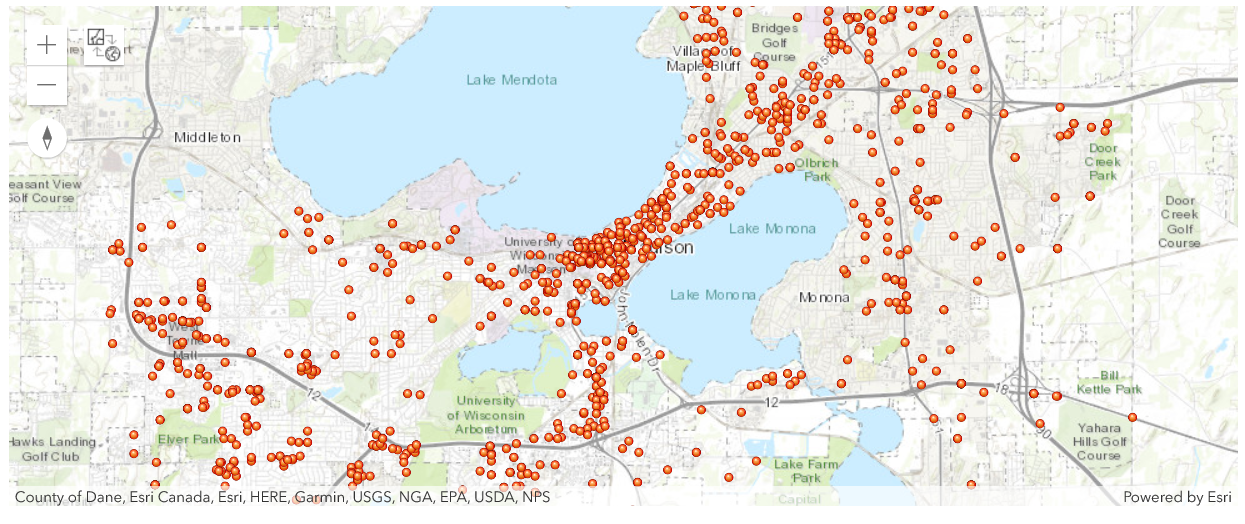

In [24]:
result_map.add_layer(madison_crime_layer)

# Create a hot spot map of crime densities

ArcGIS has a set of tools to help us identify, quantify and visualize spatial patterns in our data by identifying areas of statistically significant clusters.

The [`find_hot_spots`](https://developers.arcgis.com/rest/services-reference/find-hot-spots.htm) tool allows us to visualize areas having such clusters.

In [25]:
from arcgis.features.analyze_patterns import find_hot_spots

In [26]:
crime_hotspots_madison = find_hot_spots(madison_crime_layer, 
                                        context={"extent":
                                                 {"xmin":-10091700.007046243,"ymin":5225939.095608932,
                                                  "xmax":-9731528.729766665,"ymax":5422840.88047145,
                                                  "spatialReference":{"wkid":102100,"latestWkid":3857}}},
                                        output_name="crime_hotspots_madison")

In [27]:
hotspot_map = gis.map('Madison, Wisconsin', 12)
hotspot_map.basemap = 'terrain'

In [28]:
hotspot_map

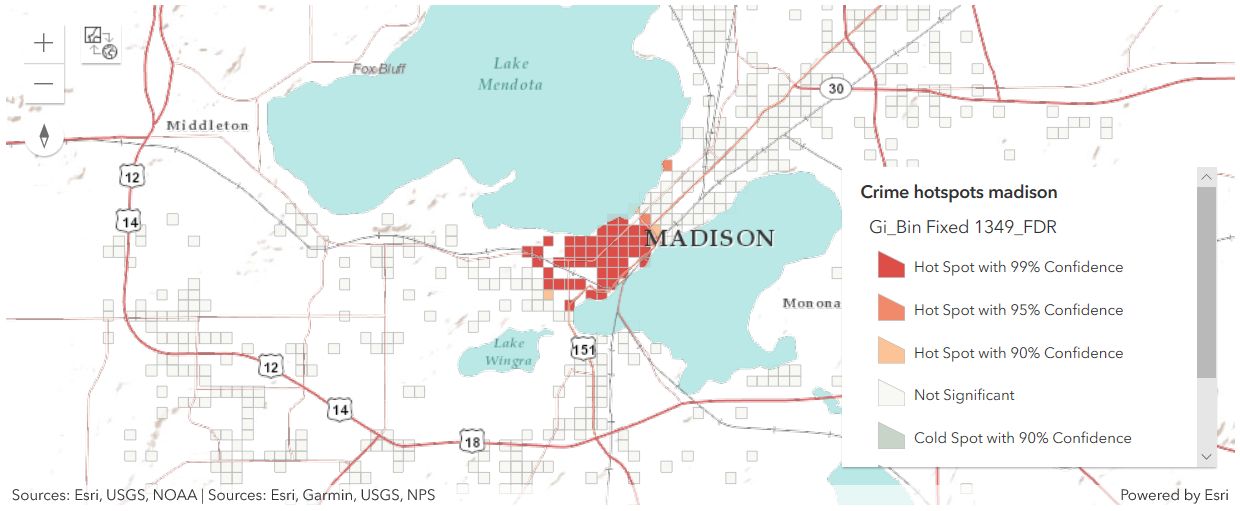

In [29]:
hotspot_map.add_layer(crime_hotspots_madison)
hotspot_map.legend = True

# Conclusion

This sample demonstrates how `EntityRecognizer()` from `arcgis.learn` can be used for information extraction from crime incident reports, which is an essential requirement for crime analysis. Then, we see how can this information be geocoded and visualized on a map for further analysis.

# References

[1]: [Police Incident Reports(City of Madison)](https://www.cityofmadison.com/police/newsroom/incidentreports/)

[2]: [F1 score](https://en.wikipedia.org/wiki/F1_score)